In [1]:
import os
import glob
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Function to extract the year from the filename
def extract_year(filename):
    match = re.search(r'\d{4}', filename)
    return int(match.group()) if match else None

# Directory where the Excel files are located
excel_dir = 'proof_of_concept_2\Season_Files'

# Find all Excel files in the directory
excel_files_ranks = glob.glob(os.path.join(excel_dir, '*team_ranks.xls*'))
excel_files_coaches = glob.glob(os.path.join(excel_dir, '*team_coaches.xls*'))
excel_files_stats = glob.glob(os.path.join(excel_dir, '*team_stats.xls*'))
excel_files_games = glob.glob(os.path.join(excel_dir, '*team_games.xls*'))

# Initialize an empty DataFrame
combined_df_ranks = pd.DataFrame()
combined_df_coaches = pd.DataFrame()
combined_df_stats = pd.DataFrame()
combined_df_games = pd.DataFrame()
# Loop through the Excel files
for excel_file in excel_files_ranks:
    # Extract the year from the filename
    year = extract_year(excel_file)

    # Read the Excel file into a DataFrame
    df = pd.read_excel(excel_file)

    # Add the extracted year as a new column
    df['Year'] = year

    # Concatenate the DataFrame to the combined one
    combined_df_ranks = pd.concat([combined_df_ranks, df], ignore_index=True)
    
for excel_file in excel_files_coaches:
    # Extract the year from the filename
    year = extract_year(excel_file)

    # Read the Excel file into a DataFrame
    df = pd.read_excel(excel_file)

    # Add the extracted year as a new column
    df['Year'] = year

    # Concatenate the DataFrame to the combined one
    combined_df_coaches = pd.concat([combined_df_coaches, df], ignore_index=True)
    
for excel_file in excel_files_stats:
    # Extract the year from the filename
    year = extract_year(excel_file)

    # Read the Excel file into a DataFrame
    df = pd.read_excel(excel_file)

    # Add the extracted year as a new column
    df['Year'] = year

    # Concatenate the DataFrame to the combined one
    combined_df_stats = pd.concat([combined_df_stats, df], ignore_index=True)
for excel_file in excel_files_games:
    # Extract the year from the filename
    year = extract_year(excel_file)

    # Read the Excel file into a DataFrame
    df = pd.read_excel(excel_file)

    # Add the extracted year as a new column
    df['Year'] = year

    # Concatenate the DataFrame to the combined one
    combined_df_games = pd.concat([combined_df_games, df], ignore_index=True)



In [2]:
combined_df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          448 non-null    object
 1   Unnamed: 1          7588 non-null   object
 2   year                7588 non-null   int64 
 3   week                7588 non-null   object
 4   day_of_week         7588 non-null   object
 5   date                7588 non-null   object
 6   game_start_time     7588 non-null   object
 7   team_win_or_lose    7588 non-null   object
 8   overtime_game       7588 non-null   object
 9   record_after_game   7588 non-null   object
 10  team_playing_where  7588 non-null   object
 11  game_opponent       7588 non-null   object
 12  points_forced       7588 non-null   int64 
 13  yds_forced          7588 non-null   int64 
 14  tunovers_lost       7588 non-null   int64 
 15  first_downs_forced  7588 non-null   int64 
 16  pass_yds_forced     7588

In [3]:
# Excel had one large cell block for the corresponding team. ffill()  was used to fill in missing values until  a non-missing value is found.
combined_df_games['Unnamed: 0'] = combined_df_games['Unnamed: 0'].ffill()

In [4]:
combined_df_games.head()

,Unnamed: 0,Unnamed: 1,year,week,day_of_week,date,game_start_time,team_win_or_lose,overtime_game,record_after_game,...,first_downs_forced,pass_yds_forced,rush_yds_forced,points_given,yds_given,tunovers_forced,first_downs_given,pass_yds_given,rush_yds_given,Year
0,New England Patriots,1,2010,1,Sun,September 12,1:02PM ET,W,RG,1-0,...,20,258,118,24,428,2,26,341,87,2010
1,New England Patriots,2,2010,2,Sun,September 19,4:16PM ET,L,RG,1-1,...,20,239,52,28,336,0,23,200,136,2010
2,New England Patriots,3,2010,3,Sun,September 26,1:02PM ET,W,RG,2-1,...,25,245,200,30,374,2,19,240,134,2010
3,New England Patriots,4,2010,4,Mon,October 4,8:41PM ET,W,RG,3-1,...,19,146,119,14,400,4,23,308,92,2010
4,New England Patriots,6,2010,6,Sun,October 17,1:02PM ET,W,OT,4-1,...,23,267,127,20,377,0,21,278,99,2010


In [5]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(combined_df_games):
    # Derive column 'derivedCol' from column: 'year'
    # Transform based on the following examples:
    #     year    Output
    # 1: 2010L => "2010"
    combined_df_games.insert(3, "year_str", combined_df_games.apply(lambda row : f'{row["year"]:01.0f}', axis=1))
    # Derive column 'derivedCol' from columns: 'game_start_time', 'date', 'year_str'
    # Transform based on the following examples:
    #    date            game_start_time  year_str    Output
    # 1: "September 12"  "1:02PM ET"      "2010"   => "September 12, 2010"
    # 2: "September 19"  "4:16PM ET"      "2010"   => "September 19, 2010"
    # 3: "September 26"  "1:02PM ET"      "2010"   => "September 26, 2010"
    # 4: "October 4"     "8:41PM ET"      "2010"   => "October 4, 2010"
    combined_df_games.insert(8, "derivedCol", combined_df_games["date"] + ", " + combined_df_games["year_str"])
    # Derive column 'comb_datetime' from columns: 'derivedCol', 'game_start_time'
    # Transform based on the following examples:
    #    derivedCol            game_start_time    Output
    # 1: "September 12, 2010"  "1:02PM ET"     => "September 12, 2010"
    combined_df_games.insert(9, "comb_datetime", combined_df_games["game_start_time"]+' '+combined_df_games["derivedCol"])
    return combined_df_games

combined_df_games_clean = clean_data(combined_df_games.copy())
combined_df_games_clean.head()

,Unnamed: 0,Unnamed: 1,year,year_str,week,day_of_week,date,game_start_time,derivedCol,comb_datetime,...,first_downs_forced,pass_yds_forced,rush_yds_forced,points_given,yds_given,tunovers_forced,first_downs_given,pass_yds_given,rush_yds_given,Year
0,New England Patriots,1,2010,2010,1,Sun,September 12,1:02PM ET,"September 12, 2010","1:02PM ET September 12, 2010",...,20,258,118,24,428,2,26,341,87,2010
1,New England Patriots,2,2010,2010,2,Sun,September 19,4:16PM ET,"September 19, 2010","4:16PM ET September 19, 2010",...,20,239,52,28,336,0,23,200,136,2010
2,New England Patriots,3,2010,2010,3,Sun,September 26,1:02PM ET,"September 26, 2010","1:02PM ET September 26, 2010",...,25,245,200,30,374,2,19,240,134,2010
3,New England Patriots,4,2010,2010,4,Mon,October 4,8:41PM ET,"October 4, 2010","8:41PM ET October 4, 2010",...,19,146,119,14,400,4,23,308,92,2010
4,New England Patriots,6,2010,2010,6,Sun,October 17,1:02PM ET,"October 17, 2010","1:02PM ET October 17, 2010",...,23,267,127,20,377,0,21,278,99,2010


In [6]:
def clean_data(combined_df_games_clean):
    # Drop column: 'year'
    combined_df_games_clean = combined_df_games_clean.drop(columns=['year', 'year_str', 'Unnamed: 1', 'day_of_week', 'date', 'game_start_time', 'derivedCol'])
    # Performed 26 aggregations grouped on columns: 'Unnamed: 0', 'Year'
    combined_df_games_clean = combined_df_games_clean.groupby(['Unnamed: 0', 'Year']).agg(team_game_count=('team_win_or_lose', 'count'), 
                                                                                          record_after_game_last=('record_after_game', 'last'), 
                                                                                          points_forced_mean=('points_forced', 'mean'), 
                                                                                          yds_forced_mean=('yds_forced', 'mean'), 
                                                                                          tunovers_lost_mean=('tunovers_lost', 'mean'), 
                                                                                          first_downs_forced_mean=('first_downs_forced', 'mean'), 
                                                                                          pass_yds_forced_mean=('pass_yds_forced', 'mean'), 
                                                                                          rush_yds_forced_mean=('rush_yds_forced', 'mean'), 
                                                                                          points_given_mean=('points_given', 'mean'), 
                                                                                          yds_given_mean=('yds_given', 'mean'), 
                                                                                          tunovers_forced_mean=('tunovers_forced', 'mean'), 
                                                                                          first_downs_given_mean=('first_downs_given', 'mean'), 
                                                                                          pass_yds_given_mean=('pass_yds_given', 'mean'), 
                                                                                          rush_yds_given_mean=('rush_yds_given', 'mean')).reset_index()
    return combined_df_games_clean

combined_df_games_clean_1 = clean_data(combined_df_games_clean.copy())
combined_df_games_clean_1.head(15)

,Unnamed: 0,Year,team_game_count,record_after_game_last,points_forced_mean,yds_forced_mean,tunovers_lost_mean,first_downs_forced_mean,pass_yds_forced_mean,rush_yds_forced_mean,points_given_mean,yds_given_mean,tunovers_forced_mean,first_downs_given_mean,pass_yds_given_mean,rush_yds_given_mean
0,Arizona Cardinals,2010,16,5-11,18.062500,269.312500,2.187500,15.062500,182.562500,86.750000,27.125000,373.562500,1.875000,21.187500,228.375000,145.187500
1,Arizona Cardinals,2011,16,8-8,19.500000,324.500000,2.000000,17.875000,222.937500,101.562500,21.750000,355.125000,1.187500,20.812500,231.000000,124.125000
2,Arizona Cardinals,2012,16,5-11,15.625000,263.062500,2.125000,15.375000,187.812500,75.250000,22.312500,337.812500,2.062500,18.000000,200.812500,137.000000
3,Arizona Cardinals,2013,16,10-6,23.687500,346.375000,1.937500,20.562500,250.125000,96.250000,20.250000,317.437500,1.875000,19.312500,233.000000,84.437500
4,Arizona Cardinals,2014,17,11-6,19.176471,305.529412,1.176471,18.235294,227.000000,78.529412,19.176471,369.235294,1.647059,19.117647,255.882353,113.352941
5,Arizona Cardinals,2015,18,14-4,29.444444,399.333333,1.833333,23.000000,287.277778,112.055556,21.222222,333.833333,1.944444,17.944444,236.777778,97.055556
6,Arizona Cardinals,2016,16,7-8-1,26.125000,366.750000,1.750000,23.000000,258.500000,108.250000,22.625000,305.187500,1.750000,18.312500,210.312500,94.875000
7,Arizona Cardinals,2017,16,8-8,18.437500,314.125000,1.562500,19.375000,227.500000,86.625000,22.562500,310.812500,1.312500,17.687500,221.312500,89.500000
8,Arizona Cardinals,2018,16,3-13,14.062500,241.562500,1.750000,14.937500,157.687500,83.875000,26.562500,358.812500,1.000000,22.312500,203.875000,154.937500
9,Arizona Cardinals,2019,16,5-10-1,22.562500,341.687500,1.125000,19.625000,217.312500,124.375000,27.625000,402.000000,1.062500,23.437500,281.875000,120.125000


In [7]:
from decimal import Decimal, ROUND_HALF_UP

def clean_data(combined_df_games_clean_1):
    # Derive column 'Team_Wins' from column: 'record_after_game_last'
    # Transform based on the following examples:
    #    record_after_game_last    Output
    # 1: "5-11"                 => "5"
    combined_df_games_clean_1.insert(4, "Team_Wins", combined_df_games_clean_1["record_after_game_last"].str.split("-").str[0])
    # Derive column 'Team_Loses' from column: 'record_after_game_last'
    # Transform based on the following examples:
    #    record_after_game_last    Output
    # 1: "5-11"                 => "11"
    combined_df_games_clean_1.insert(5, "Team_Losses", combined_df_games_clean_1["record_after_game_last"].str.split("-").str[-1])
    # Derive column 'Team_Ties' from column: 'record_after_game_last'
    
    def Team_Ties(record_after_game_last):
        """
        Transform based on the following examples:
           record_after_game_last    Output
        1: "5-10-1"               => "1"
        2: "8-8"                  => "0"
        """
        split1 = record_after_game_last.split("-")
        if len(record_after_game_last) - len(record_after_game_last.replace("-", "")) == 1:
            source = Decimal(str(float(split1[-1].replace(",", ""))))
            delta = Decimal(str(100))
            number1 = (source / delta).quantize(0, ROUND_HALF_UP) * delta
            return f"{number1:01.0f}"
    
        if len(record_after_game_last) - len(record_after_game_last.replace("-", "")) == 2:
            return split1[-1]
    
        return None
    
    combined_df_games_clean_1.insert(6, "Team_Ties", combined_df_games_clean_1.apply(lambda row : Team_Ties(row["record_after_game_last"]), axis=1))
    return combined_df_games_clean_1

combined_df_games_clean_2 = clean_data(combined_df_games_clean_1.copy())
combined_df_games_clean_2.head()

,Unnamed: 0,Year,team_game_count,record_after_game_last,Team_Wins,Team_Losses,Team_Ties,points_forced_mean,yds_forced_mean,tunovers_lost_mean,first_downs_forced_mean,pass_yds_forced_mean,rush_yds_forced_mean,points_given_mean,yds_given_mean,tunovers_forced_mean,first_downs_given_mean,pass_yds_given_mean,rush_yds_given_mean
0,Arizona Cardinals,2010,16,5-11,5,11,0,18.062500,269.312500,2.187500,15.062500,182.5625,86.750000,27.125000,373.562500,1.875000,21.187500,228.375000,145.187500
1,Arizona Cardinals,2011,16,8-8,8,8,0,19.500000,324.500000,2.000000,17.875000,222.9375,101.562500,21.750000,355.125000,1.187500,20.812500,231.000000,124.125000
2,Arizona Cardinals,2012,16,5-11,5,11,0,15.625000,263.062500,2.125000,15.375000,187.8125,75.250000,22.312500,337.812500,2.062500,18.000000,200.812500,137.000000
3,Arizona Cardinals,2013,16,10-6,10,6,0,23.687500,346.375000,1.937500,20.562500,250.1250,96.250000,20.250000,317.437500,1.875000,19.312500,233.000000,84.437500
4,Arizona Cardinals,2014,17,11-6,11,6,0,19.176471,305.529412,1.176471,18.235294,227.0000,78.529412,19.176471,369.235294,1.647059,19.117647,255.882353,113.352941


In [8]:
# Change Text from Season Records to integers
combined_df_games_clean_2['Team_Wins'] = combined_df_games_clean_2['Team_Wins'].astype('int64')
combined_df_games_clean_2['Team_Losses'] = combined_df_games_clean_2['Team_Losses'].astype('int64')
combined_df_games_clean_2['Team_Ties'] = combined_df_games_clean_2['Team_Ties'].astype('int64')

In [9]:
# Create column for a teams win percentage in a season
combined_df_games_clean_2['Team_Win_Pct'] = combined_df_games_clean_2['Team_Wins'] / combined_df_games_clean_2['team_game_count']
combined_df_games_clean_2.head()

,Unnamed: 0,Year,team_game_count,record_after_game_last,Team_Wins,Team_Losses,Team_Ties,points_forced_mean,yds_forced_mean,tunovers_lost_mean,first_downs_forced_mean,pass_yds_forced_mean,rush_yds_forced_mean,points_given_mean,yds_given_mean,tunovers_forced_mean,first_downs_given_mean,pass_yds_given_mean,rush_yds_given_mean,Team_Win_Pct
0,Arizona Cardinals,2010,16,5-11,5,11,0,18.062500,269.312500,2.187500,15.062500,182.5625,86.750000,27.125000,373.562500,1.875000,21.187500,228.375000,145.187500,0.312500
1,Arizona Cardinals,2011,16,8-8,8,8,0,19.500000,324.500000,2.000000,17.875000,222.9375,101.562500,21.750000,355.125000,1.187500,20.812500,231.000000,124.125000,0.500000
2,Arizona Cardinals,2012,16,5-11,5,11,0,15.625000,263.062500,2.125000,15.375000,187.8125,75.250000,22.312500,337.812500,2.062500,18.000000,200.812500,137.000000,0.312500
3,Arizona Cardinals,2013,16,10-6,10,6,0,23.687500,346.375000,1.937500,20.562500,250.1250,96.250000,20.250000,317.437500,1.875000,19.312500,233.000000,84.437500,0.625000
4,Arizona Cardinals,2014,17,11-6,11,6,0,19.176471,305.529412,1.176471,18.235294,227.0000,78.529412,19.176471,369.235294,1.647059,19.117647,255.882353,113.352941,0.647059


In [10]:
#########MASTER DATA FRAME FOR LIST OF PLAYOFF TEAMS DO NOT DELETE!!!!!!!!!!!!!!!#########
combined_df_games_trial=combined_df_games.copy()
#### 1-9 on the ASCII Table is different from 10-18, so we needed two seperate methods###
range_to_drop=list("1" "2" "3" "4" "5" "6" "7" "8" "9" "10" "Wild Card")
combined_df_games_trial3=combined_df_games_trial.drop(combined_df_games_trial[(combined_df_games_trial
                                                                              ["week"].isin(range_to_drop))].index,axis=0)
###10-18######
combined_df_games_trial4=combined_df_games_trial3.drop(
    combined_df_games_trial3[(combined_df_games_trial3["week"]>="1")&
                           (combined_df_games_trial3["week"]<="16")].index,axis=0)
master_df_games=combined_df_games_trial4.copy()
master_df_games=master_df_games[['Unnamed: 0',"week","Year"]]
master_df_games

,Unnamed: 0,week,Year
15,New England Patriots,17,2010
16,New England Patriots,Division,2010
32,Philadelphia Eagles,17,2010
33,Philadelphia Eagles,Wild Card,2010
49,Oakland Raiders,17,2010
...,...,...,...
7553,Chicago Bears,18,2023
7569,Denver Broncos,17,2023
7570,Denver Broncos,18,2023
7586,New York Giants,17,2023


In [11]:
# Merge ranks for a team during that particular season
master_df_all=pd.merge(master_df_games,combined_df_ranks,on=["Year","Unnamed: 0"],how="left")
master_df_all.drop_duplicates(subset=['Year', 'Unnamed: 0'], keep='last', inplace=True)
master_df_all.head(33)


,Unnamed: 0,week,Year,points_forced_rank,yds_forced_rank,tunovers_lost_rank,fumbles_lost_rank,first_downs_forced_rank,pass_attempts_forced_rank,pass_yds_forced_rank,...,rush_yds_given_rank,rush_td_given_rank,yds_per_run_given_rank,pct_scoring_drives_for_opp_rank,pct_turnover_drives_for_opp_rank,avg_starting_fld_pos_opp_rank,avg_drive_duration_for_opp_rank,avg_plays_per_drive_for_opp_rank,avg_yds_per_drive_for_opp_rank,avg_points_per_drive_for_opp_rank
1,New England Patriots,Division,2010,1,8,1,1,6,20,11,...,11,10,16,21,1,6,29,31,30,16
3,Philadelphia Eagles,Wild Card,2010,3,2,12,21,10,11,9,...,15,16,14,18,5,4,5,6,8,22
4,Oakland Raiders,17,2010,6,10,15,13,16,24,23,...,29,20,23,20,31,26,2,2,5,19
6,New Orleans Saints,Wild Card,2010,11,6,21,9,5,2,3,...,16,18,17,16,18,14,22,24,16,11
8,Atlanta Falcons,Division,2010,5,16,3,6,4,8,15,...,10,8,27,28,7,1,10,12,20,7
9,Houston Texans,17,2010,9,3,4,2,2,10,4,...,13,26,11,2,27,15,30,29,32,32
10,Arizona Cardinals,17,2010,26,31,28,28,31,11,31,...,30,29,20,4,15,28,23,20,19,27
11,Cincinnati Bengals,17,2010,22,20,27,25,12,5,13,...,19,24,21,11,16,15,11,11,18,23
12,Denver Broncos,17,2010,19,13,16,27,14,7,7,...,31,32,29,1,32,27,15,16,27,30
13,Dallas Cowboys,17,2010,7,7,20,17,9,9,6,...,12,12,18,8,8,15,8,8,21,28


In [12]:
master_df_all.tail(33)

,Unnamed: 0,week,Year,points_forced_rank,yds_forced_rank,tunovers_lost_rank,fumbles_lost_rank,first_downs_forced_rank,pass_attempts_forced_rank,pass_yds_forced_rank,...,rush_yds_given_rank,rush_td_given_rank,yds_per_run_given_rank,pct_scoring_drives_for_opp_rank,pct_turnover_drives_for_opp_rank,avg_starting_fld_pos_opp_rank,avg_drive_duration_for_opp_rank,avg_plays_per_drive_for_opp_rank,avg_yds_per_drive_for_opp_rank,avg_points_per_drive_for_opp_rank
777,Los Angeles Rams,18,2022,27,32,17,7,27,24,27,...,13,10,13,6,12,29,31,31,27,23
779,Washington Commanders,18,2023,25,24,29,20,21,1,18,...,27,17,26,1,26,29,20,26,32,32
783,Tampa Bay Buccaneers,Division,2023,20,23,6,13,25,19,17,...,5,8,8,18,8,4,25,25,23,12
786,Cleveland Browns,Wild Card,2023,10,16,32,29,18,5,19,...,11,17,19,32,17,25,1,1,1,2
791,San Francisco 49ers,SuperBowl,2023,3,2,6,4,2,32,4,...,3,4,14,20,2,1,23,27,14,9
793,Los Angeles Chargers,18,2023,21,18,16,27,22,3,13,...,17,26,13,15,22,21,23,20,25,23
795,Seattle Seahawks,18,2023,17,21,5,2,23,17,14,...,31,30,27,5,21,7,32,30,29,29
797,Carolina Panthers,18,2023,31,32,14,16,27,13,32,...,23,32,12,11,32,30,11,7,5,27
801,Green Bay Packers,Division,2023,12,11,6,9,11,15,12,...,28,17,23,8,23,9,29,29,26,22
804,Dallas Cowboys,Wild Card,2023,1,5,2,4,1,8,3,...,16,11,15,26,4,7,14,15,9,10


In [13]:
# Possible values for a team ending their season
master_df_all['week'].unique()

array(['Division', 'Wild Card', '17', 'SuperBowl', 'Conf. Champ.', '18'],
      dtype=object)

In [14]:
# Replace names of playoff week with a number
# Started with 19 because around 2021, the NFL went from 17 games to 18 games seasons. Starting at 19 avoids any overlap.
new_weeks = {'Wild Card':'19',
                   'Division':'20', 'Conf. Champ.':'21', 'SuperBowl': '22'}


for old, new in new_weeks.items():
    master_df_all.week = master_df_all.week.str.replace(old,new)

master_df_all.head(15)

,Unnamed: 0,week,Year,points_forced_rank,yds_forced_rank,tunovers_lost_rank,fumbles_lost_rank,first_downs_forced_rank,pass_attempts_forced_rank,pass_yds_forced_rank,...,rush_yds_given_rank,rush_td_given_rank,yds_per_run_given_rank,pct_scoring_drives_for_opp_rank,pct_turnover_drives_for_opp_rank,avg_starting_fld_pos_opp_rank,avg_drive_duration_for_opp_rank,avg_plays_per_drive_for_opp_rank,avg_yds_per_drive_for_opp_rank,avg_points_per_drive_for_opp_rank
1,New England Patriots,20,2010,1,8,1,1,6,20,11,...,11,10,16,21,1,6,29,31,30,16
3,Philadelphia Eagles,19,2010,3,2,12,21,10,11,9,...,15,16,14,18,5,4,5,6,8,22
4,Oakland Raiders,17,2010,6,10,15,13,16,24,23,...,29,20,23,20,31,26,2,2,5,19
6,New Orleans Saints,19,2010,11,6,21,9,5,2,3,...,16,18,17,16,18,14,22,24,16,11
8,Atlanta Falcons,20,2010,5,16,3,6,4,8,15,...,10,8,27,28,7,1,10,12,20,7
9,Houston Texans,17,2010,9,3,4,2,2,10,4,...,13,26,11,2,27,15,30,29,32,32
10,Arizona Cardinals,17,2010,26,31,28,28,31,11,31,...,30,29,20,4,15,28,23,20,19,27
11,Cincinnati Bengals,17,2010,22,20,27,25,12,5,13,...,19,24,21,11,16,15,11,11,18,23
12,Denver Broncos,17,2010,19,13,16,27,14,7,7,...,31,32,29,1,32,27,15,16,27,30
13,Dallas Cowboys,17,2010,7,7,20,17,9,9,6,...,12,12,18,8,8,15,8,8,21,28


In [15]:
# Most Important Step
# Assigns weights to how far the team went in that season
Week_weights = {
    '22': 1.0,
    '21': 0.9,
    '20': 0.8,
    '19': 0.7,
    '18': 0.65,
    '17': 0.65
}

In [16]:
# Maps above weights to each individual team
master_df_all['Week_Weights'] = master_df_all['week'].map(Week_weights)
master_df_all.head(5)

,Unnamed: 0,week,Year,points_forced_rank,yds_forced_rank,tunovers_lost_rank,fumbles_lost_rank,first_downs_forced_rank,pass_attempts_forced_rank,pass_yds_forced_rank,...,rush_td_given_rank,yds_per_run_given_rank,pct_scoring_drives_for_opp_rank,pct_turnover_drives_for_opp_rank,avg_starting_fld_pos_opp_rank,avg_drive_duration_for_opp_rank,avg_plays_per_drive_for_opp_rank,avg_yds_per_drive_for_opp_rank,avg_points_per_drive_for_opp_rank,Week_Weights
1,New England Patriots,20,2010,1,8,1,1,6,20,11,...,10,16,21,1,6,29,31,30,16,0.80
3,Philadelphia Eagles,19,2010,3,2,12,21,10,11,9,...,16,14,18,5,4,5,6,8,22,0.70
4,Oakland Raiders,17,2010,6,10,15,13,16,24,23,...,20,23,20,31,26,2,2,5,19,0.65
6,New Orleans Saints,19,2010,11,6,21,9,5,2,3,...,18,17,16,18,14,22,24,16,11,0.70
8,Atlanta Falcons,20,2010,5,16,3,6,4,8,15,...,8,27,28,7,1,10,12,20,7,0.80


In [17]:
master_df_all.head()

,Unnamed: 0,week,Year,points_forced_rank,yds_forced_rank,tunovers_lost_rank,fumbles_lost_rank,first_downs_forced_rank,pass_attempts_forced_rank,pass_yds_forced_rank,...,rush_td_given_rank,yds_per_run_given_rank,pct_scoring_drives_for_opp_rank,pct_turnover_drives_for_opp_rank,avg_starting_fld_pos_opp_rank,avg_drive_duration_for_opp_rank,avg_plays_per_drive_for_opp_rank,avg_yds_per_drive_for_opp_rank,avg_points_per_drive_for_opp_rank,Week_Weights
1,New England Patriots,20,2010,1,8,1,1,6,20,11,...,10,16,21,1,6,29,31,30,16,0.80
3,Philadelphia Eagles,19,2010,3,2,12,21,10,11,9,...,16,14,18,5,4,5,6,8,22,0.70
4,Oakland Raiders,17,2010,6,10,15,13,16,24,23,...,20,23,20,31,26,2,2,5,19,0.65
6,New Orleans Saints,19,2010,11,6,21,9,5,2,3,...,18,17,16,18,14,22,24,16,11,0.70
8,Atlanta Falcons,20,2010,5,16,3,6,4,8,15,...,8,27,28,7,1,10,12,20,7,0.80


In [18]:
master_df_all=pd.merge(master_df_all,combined_df_games_clean_2,on=["Year","Unnamed: 0"],how="left")
master_df_all.head(5)

,Unnamed: 0,week,Year,points_forced_rank,yds_forced_rank,tunovers_lost_rank,fumbles_lost_rank,first_downs_forced_rank,pass_attempts_forced_rank,pass_yds_forced_rank,...,first_downs_forced_mean,pass_yds_forced_mean,rush_yds_forced_mean,points_given_mean,yds_given_mean,tunovers_forced_mean,first_downs_given_mean,pass_yds_given_mean,rush_yds_given_mean,Team_Win_Pct
0,New England Patriots,20,2010,1,8,1,1,6,20,11,...,21.235294,241.529412,122.705882,20.058824,363.411765,2.235294,21.294118,254.705882,108.705882,0.823529
1,Philadelphia Eagles,19,2010,3,2,12,21,10,11,9,...,20.000000,245.705882,141.470588,23.411765,326.117647,2.117647,19.352941,214.117647,112.000000,0.588235
2,Oakland Raiders,17,2010,6,10,15,13,16,24,23,...,19.125000,198.750000,155.875000,23.187500,322.812500,1.500000,18.250000,189.187500,133.625000,0.500000
3,New Orleans Saints,19,2010,11,6,21,9,5,2,3,...,22.529412,284.588235,93.882353,20.470588,312.647059,1.529412,17.176471,198.117647,114.529412,0.647059
4,Atlanta Falcons,20,2010,5,16,3,6,4,8,15,...,21.647059,218.588235,113.882353,19.764706,338.882353,1.882353,18.352941,233.588235,105.294118,0.764706


In [19]:
# "Unnamed" Column is the name of the teams
master_df_all.rename(columns={"Unnamed: 0": "Team_Names"}, inplace=True)

In [20]:
# Engineered features to  be used for the model
master_df_all['Relative_Strength'] = master_df_all['points_forced_mean'] / master_df_all['points_given_mean']
master_df_all['Offense_Efficiency'] = master_df_all['points_forced_mean'] / master_df_all['yds_forced_mean']
master_df_all['Off_Pass_Yds_Ratio'] = master_df_all['pass_yds_forced_mean'] / master_df_all['yds_forced_mean']
master_df_all['Off_Rush_Yds_Ratio'] = master_df_all['rush_yds_forced_mean'] / master_df_all['yds_forced_mean']
master_df_all['Off_Pass_Rush_Ratio'] = master_df_all['pass_yds_forced_mean'] / master_df_all['rush_yds_forced_mean'] 
master_df_all['Defense_Efficiency'] = -1 * master_df_all['points_given_mean'] / master_df_all['yds_given_mean']
master_df_all['Def_Pass_Yds_Ratio'] = master_df_all['pass_yds_given_mean'] / master_df_all['yds_given_mean']
master_df_all['Def_Rush_Yds_Ratio'] = master_df_all['rush_yds_given_mean'] / master_df_all['yds_given_mean']
master_df_all['Def_Pass_Rush_Ratio'] = master_df_all['pass_yds_given_mean'] / master_df_all['rush_yds_given_mean']
master_df_all['Turnover_Margin'] = master_df_all['tunovers_forced_mean'] / master_df_all['tunovers_lost_mean']
# Most important Variable (Target Variable)
master_df_all['Season_Performance_Factor'] = master_df_all['Week_Weights'] * master_df_all['Team_Win_Pct']
master_df_all.drop(['Week_Weights', 'Team_Wins', 'Team_Losses', 'Team_Ties','record_after_game_last'], axis=1, inplace=True)

In [21]:
master_df_all.head()

,Team_Names,week,Year,points_forced_rank,yds_forced_rank,tunovers_lost_rank,fumbles_lost_rank,first_downs_forced_rank,pass_attempts_forced_rank,pass_yds_forced_rank,...,Offense_Efficiency,Off_Pass_Yds_Ratio,Off_Rush_Yds_Ratio,Off_Pass_Rush_Ratio,Defense_Efficiency,Def_Pass_Yds_Ratio,Def_Rush_Yds_Ratio,Def_Pass_Rush_Ratio,Turnover_Margin,Season_Performance_Factor
0,New England Patriots,20,2010,1,8,1,1,6,20,11,...,0.087048,0.663114,0.336886,1.968360,-0.055196,0.700874,0.299126,2.343074,3.454545,0.658824
1,Philadelphia Eagles,19,2010,3,2,12,21,10,11,9,...,0.069128,0.634610,0.365390,1.736798,-0.071789,0.656566,0.343434,1.911765,1.384615,0.411765
2,Oakland Raiders,17,2010,6,10,15,13,16,24,23,...,0.072259,0.560451,0.439549,1.275060,-0.071830,0.586060,0.413940,1.415809,0.923077,0.325000
3,New Orleans Saints,19,2010,11,6,21,9,5,2,3,...,0.065278,0.751943,0.248057,3.031328,-0.065475,0.633678,0.366322,1.729841,0.812500,0.452941
4,Atlanta Falcons,20,2010,5,16,3,6,4,8,15,...,0.076964,0.657466,0.342534,1.919421,-0.058323,0.689290,0.310710,2.218436,1.523810,0.611765


In [22]:
# Normalizes and standardizes the number values within each column
sc = StandardScaler()

In [23]:
# Visual Python: Machine Learning > Fit/Predict
master_df_all_stand = master_df_all.copy()   # Create a copy of the DataFrame to get normalized
num_d = master_df_all_stand.select_dtypes(exclude=['object']) # Uses only  numeric data types (float64, int64)
master_df_all_stand[num_d.columns] = sc.fit_transform(num_d) # Standardize numerical features to have mean 0 
master_df_all_stand = pd.get_dummies(master_df_all_stand)     # Convert categorical variables into dummy variables with values 0 or 1 corresponding to the column name
master_df_all_stand

,Year,points_forced_rank,yds_forced_rank,tunovers_lost_rank,fumbles_lost_rank,first_downs_forced_rank,pass_attempts_forced_rank,pass_yds_forced_rank,pass_td_forced_rank,interceptions_thrown_rank,...,Team_Names_Tennessee Titans,Team_Names_Washington Commanders,Team_Names_Washington Football Team,Team_Names_Washington Redskins,week_17,week_18,week_19,week_20,week_21,week_22
0,-1.612452,-1.670116,-0.919756,-1.581973,-1.496598,-1.123905,0.389388,-0.594109,-1.619529,-1.567504,...,False,False,False,False,False,False,False,True,False,False
1,-1.612452,-1.453651,-1.569508,-0.396275,0.633926,-0.690871,-0.585775,-0.810676,-0.858882,-0.706782,...,False,False,False,False,False,False,True,False,False,False
2,-1.612452,-1.128953,-0.703172,-0.072903,-0.218284,-0.041322,0.822793,0.705293,0.988405,0.046350,...,False,False,False,False,True,False,False,False,False,False
3,-1.612452,-0.587790,-1.136340,0.573841,-0.644388,-1.232163,-1.560937,-1.460377,-1.510865,1.552614,...,False,False,False,False,False,False,True,False,False,False
4,-1.612452,-1.237186,-0.053421,-1.366392,-0.963967,-1.340421,-0.910829,-0.160975,-0.858882,-1.244733,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,1.612452,0.819234,0.271455,-1.043020,-1.177019,-0.257838,0.822793,1.030144,0.879741,-0.276421,...,False,False,False,False,False,True,False,False,False,False
444,1.612452,-0.371325,-0.486588,-1.581973,-1.177019,-0.149580,-0.477423,-1.027243,-0.424226,-1.459914,...,False,False,False,False,False,False,False,True,False,False
445,1.612452,0.169838,0.379747,0.573841,0.101295,0.391711,1.147847,1.138427,0.771077,0.584302,...,False,False,False,False,False,True,False,False,False,False
446,1.612452,0.278071,1.029498,0.142678,1.273083,0.824744,1.147847,0.813577,-0.858882,-1.244733,...,False,False,False,False,False,True,False,False,False,False


In [24]:
# Teams ending their season before the playoffs in a 17 week season is consolidate with week 18 seasons
master_df_all_stand['week_18'] = master_df_all_stand['week_18']|master_df_all_stand['week_17']

In [25]:
# Dropped after consolidation with 18 week seasons
master_df_all_stand.drop('week_17', axis=1, inplace=True)

In [26]:
# I dropped a few columns from the master_df_all_stand after reading this article https://www.blog.dailydoseofds.com/p/the-most-overlooked-problem-with
# In summary, if a set of features has an sum or product that can be predicted (ie. pass_forced + rush_forced = total_forced), then essentially this introduces a free variable in the equation and the predictions almost exactly fits the test set
# I also took out the columns win_pct and the final week of their season since that is what made the performance factors
X = master_df_all_stand[['Year', 'points_forced_rank', 'yds_forced_rank', 'tunovers_lost_rank', 'fumbles_lost_rank', 'first_downs_forced_rank', 'pass_attempts_forced_rank', 'pass_yds_forced_rank', 'pass_td_forced_rank', 'interceptions_thrown_rank', 'yds_per_pass_rank', 'rush_attempts_forced_rank', 'rush_yds_forced_rank', 'rush_td_forced_rank', 'yds_per_run_rank', 'pct_scoring_drives_for_team_rank', 'pct_turnover_drives_for_team_rank', 'avg_starting_fld_pos_rank', 'avg_drive_duration_for_team_rank', 'avg_plays_per_drive_for_team_rank', 'avg_yds_per_drive_for_team_rank', 'avg_points_per_drive_for_team_rank', 'points_given_rank', 'yds_given_rank', 'tunovers_forced_rank', 'fumbles_forced_rank', 'first_downs_given_rank', 'pass_attempts_given_rank', 'pass_yds_given_rank', 'pass_td_given_rank', 'interceptions_forced_rank', 'yds_per_pass_given_rank', 'rush_attempts_given_rank', 'rush_yds_given_rank', 'rush_td_given_rank', 'yds_per_run_given_rank', 'pct_scoring_drives_for_opp_rank', 'pct_turnover_drives_for_opp_rank', 'avg_starting_fld_pos_opp_rank', 'avg_drive_duration_for_opp_rank', 'avg_plays_per_drive_for_opp_rank', 'avg_yds_per_drive_for_opp_rank', 'avg_points_per_drive_for_opp_rank', 'points_forced_mean', 'tunovers_lost_mean', 'first_downs_forced_mean', 'pass_yds_forced_mean', 'rush_yds_forced_mean', 'points_given_mean', 'tunovers_forced_mean', 'first_downs_given_mean', 'pass_yds_given_mean', 'rush_yds_given_mean', 'Relative_Strength', 'Offense_Efficiency', 'Off_Pass_Yds_Ratio', 'Off_Pass_Rush_Ratio', 'Defense_Efficiency', 'Def_Pass_Yds_Ratio', 'Def_Pass_Rush_Ratio', 'Turnover_Margin', 'Team_Names_Arizona Cardinals', 'Team_Names_Atlanta Falcons', 'Team_Names_Baltimore Ravens', 'Team_Names_Buffalo Bills', 'Team_Names_Carolina Panthers', 'Team_Names_Chicago Bears', 'Team_Names_Cincinnati Bengals', 'Team_Names_Cleveland Browns', 'Team_Names_Dallas Cowboys', 'Team_Names_Denver Broncos', 'Team_Names_Detroit Lions', 'Team_Names_Green Bay Packers', 'Team_Names_Houston Texans', 'Team_Names_Indianapolis Colts', 'Team_Names_Jacksonville Jaguars', 'Team_Names_Kansas City Chiefs', 'Team_Names_Las Vegas Raiders', 'Team_Names_Los Angeles Chargers', 'Team_Names_Los Angeles Rams', 'Team_Names_Miami Dolphins', 'Team_Names_Minnesota Vikings', 'Team_Names_New England Patriots', 'Team_Names_New Orleans Saints', 'Team_Names_New York Giants', 'Team_Names_New York Jets', 'Team_Names_Oakland Raiders', 'Team_Names_Philadelphia Eagles', 'Team_Names_Pittsburgh Steelers', 'Team_Names_San Diego Chargers', 'Team_Names_San Francisco 49ers', 'Team_Names_Seattle Seahawks', 'Team_Names_St. Louis Rams', 'Team_Names_Tampa Bay Buccaneers', 'Team_Names_Tennessee Titans', 'Team_Names_Washington Commanders', 'Team_Names_Washington Football Team', 'Team_Names_Washington Redskins']]
y = master_df_all_stand['Season_Performance_Factor']

In [27]:
feature_names = X.columns

In [28]:
print("Number of instances:", X.shape[0])
print("Number of features:", X.shape[1])
print(feature_names)
print("Number of classes:", np.unique(y).size)

Number of instances: 448
Number of features: 98
Index(['Year', 'points_forced_rank', 'yds_forced_rank', 'tunovers_lost_rank',
       'fumbles_lost_rank', 'first_downs_forced_rank',
       'pass_attempts_forced_rank', 'pass_yds_forced_rank',
       'pass_td_forced_rank', 'interceptions_thrown_rank', 'yds_per_pass_rank',
       'rush_attempts_forced_rank', 'rush_yds_forced_rank',
       'rush_td_forced_rank', 'yds_per_run_rank',
       'pct_scoring_drives_for_team_rank', 'pct_turnover_drives_for_team_rank',
       'avg_starting_fld_pos_rank', 'avg_drive_duration_for_team_rank',
       'avg_plays_per_drive_for_team_rank', 'avg_yds_per_drive_for_team_rank',
       'avg_points_per_drive_for_team_rank', 'points_given_rank',
       'yds_given_rank', 'tunovers_forced_rank', 'fumbles_forced_rank',
       'first_downs_given_rank', 'pass_attempts_given_rank',
       'pass_yds_given_rank', 'pass_td_given_rank',
       'interceptions_forced_rank', 'yds_per_pass_given_rank',
       'rush_attempts_gi

In [29]:
print(f'The minimum season performance factor after being standarized is {min(y)}')
print(f'The maximum season performance factor after being standarized is {max(y)}')

The minimum season performance factor after being standarized is -2.0073459273333616
The maximum season performance factor after being standarized is 2.939589969029913


In [30]:
# Split the data into  training and testing sets (20% of total for testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [31]:
X_train

,Year,points_forced_rank,yds_forced_rank,tunovers_lost_rank,fumbles_lost_rank,first_downs_forced_rank,pass_attempts_forced_rank,pass_yds_forced_rank,pass_td_forced_rank,interceptions_thrown_rank,...,Team_Names_Pittsburgh Steelers,Team_Names_San Diego Chargers,Team_Names_San Francisco 49ers,Team_Names_Seattle Seahawks,Team_Names_St. Louis Rams,Team_Names_Tampa Bay Buccaneers,Team_Names_Tennessee Titans,Team_Names_Washington Commanders,Team_Names_Washington Football Team,Team_Names_Washington Redskins
66,-1.116313,0.819234,0.921207,0.142678,-0.644388,1.366036,-0.369072,0.272159,1.314397,1.122253,...,False,False,False,False,False,False,False,False,False,False
309,0.620174,-0.587790,-1.028048,0.681632,-1.070493,-0.690871,-1.452586,-1.352094,0.336422,1.014663,...,False,False,False,False,False,False,False,False,False,False
312,0.620174,-1.453651,-1.461216,1.759539,0.740452,-1.232163,-1.344234,-1.676944,-1.402201,1.767795,...,False,False,False,False,False,True,False,False,False,False
12,-1.612452,-0.263092,-0.486588,-1.474182,-1.390072,-0.582613,1.364550,1.463278,-0.641554,-1.352324,...,False,False,False,False,False,False,False,False,False,False
219,-0.124035,-1.345418,-0.919756,-0.827438,-0.218284,-1.015646,-1.235883,-1.027243,-1.619529,-0.921962,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1.116313,-1.345418,-1.461216,0.789423,1.592662,-1.665196,-1.560937,-1.352094,-1.076209,-0.491601,...,False,False,False,False,False,False,False,False,False,False
320,0.868243,-0.046627,0.163163,-0.719647,-0.431336,-0.799130,-1.344234,-1.243810,-0.315562,-0.706782,...,False,False,False,False,False,False,False,False,False,False
15,-1.612452,0.927467,0.163163,0.573841,0.633926,0.391711,-1.344234,-0.918960,0.662413,0.476711,...,False,False,False,False,False,False,False,False,False,True
125,-0.868243,-0.263092,-0.378297,1.436167,1.379609,0.283453,0.389388,0.705293,1.205733,0.476711,...,False,False,False,False,False,False,False,False,False,False


In [32]:
# Initialize the linear regression model
model = LinearRegression()

In [33]:
# Takes information from the training set to generate the coefficients for the features that will best fit the prediction line
model.fit(X_train, y_train)

LinearRegression()

In [34]:
# Values that the model predicts that y_test will be
y_pred = model.predict(X_test)
y_pred

array([-1.7830161 , -0.96424394,  1.29061906,  1.85531782,  0.42803545,
       -0.74987647, -1.72392801,  0.61263013, -0.70744784,  2.05558576,
       -0.64121267,  0.91763599, -0.18353602,  1.92128203, -1.16707294,
        0.0149407 ,  1.59860826,  1.03911107,  1.1702348 ,  1.48369988,
       -0.1168095 , -0.9929887 , -0.79132473,  1.20799277,  0.81175796,
       -0.41996375,  0.92004548, -0.11823206, -1.7112637 , -1.38175873,
       -1.02989963,  1.71013425,  0.54809761, -0.43924838, -0.57621434,
       -1.02124115,  0.22989974,  1.2521936 , -0.01266874, -1.16700494,
        0.12587617,  1.69617203, -0.37414519, -0.36083941,  0.59772262,
       -0.75662382, -0.49185321,  0.43144908,  0.17115779, -0.3041493 ,
       -1.63492964,  1.45830396,  2.53249938, -0.19021538,  0.23974014,
       -1.20130331,  0.28713761, -0.44059439, -1.411484  , -0.38694933,
        1.02094344, -0.53390406, -1.09213655,  0.488753  ,  0.14717745,
        0.32372979, -0.4498588 ,  0.05077539, -1.02330978, -1.23

In [35]:
y_test

300   -1.108895
43    -0.884282
211    1.114872
188    2.939590
129    1.397310
         ...   
154    0.014169
81     1.187146
56     0.204225
195    1.375057
37    -1.333508
Name: Season_Performance_Factor, Length: 90, dtype: float64

In [36]:

len(y_pred) == len(y_test)

True

In [37]:
model.intercept_

-0.033030479054684585

In [38]:
temp_list = list(zip(model.coef_, model.feature_names_in_))
for coef, name in sorted(temp_list, reverse=True):
    print(f'{name}: {coef}')

points_forced_mean: 1.3610992667565411
Def_Pass_Yds_Ratio: 0.8360297428334236
rush_yds_given_mean: 0.81629158946844
Relative_Strength: 0.784450005455072
Team_Names_Kansas City Chiefs: 0.6689767114608312
Team_Names_Green Bay Packers: 0.4725503283226145
Team_Names_Seattle Seahawks: 0.3273953237385976
Team_Names_Oakland Raiders: 0.3170962567879189
points_forced_rank: 0.2537591541442725
tunovers_lost_rank: 0.21398984711169433
pct_turnover_drives_for_team_rank: 0.21147635046159086
avg_yds_per_drive_for_opp_rank: 0.1959858134640013
Team_Names_Washington Commanders: 0.18995231516056657
yds_per_run_rank: 0.16771975922842622
Off_Pass_Yds_Ratio: 0.1606509317167043
Off_Pass_Rush_Ratio: 0.14644492735876435
avg_plays_per_drive_for_team_rank: 0.12480201759385502
Team_Names_New England Patriots: 0.12043392731670811
tunovers_forced_rank: 0.10849587694534141
pass_attempts_given_rank: 0.10818153421984379
Team_Names_Pittsburgh Steelers: 0.09954959740818602
Team_Names_San Francisco 49ers: 0.09590435731410

In [39]:
# Gereated by Visual Python: Machine Learning > Model Info
def vp_create_permutation_importances(model, X_train, y_train, scoring=None, sort=False):
    if isinstance(X_train, pd.core.frame.DataFrame):
        feature_names = X_train.columns
    else:
        feature_names = [ 'X{}'.format(i) for i in range(X_train.shape[1]) ]
                        
    imp = permutation_importance(model, X_train, y_train, scoring=scoring)

    df_i = pd.DataFrame(imp['importances_mean'], index=feature_names, columns=['Feature_importance'])
    df_i['Percentage'] = 10 * df_i['Feature_importance']
    if sort: df_i.sort_values(by='Feature_importance', ascending=False, inplace=True)
    df_i = df_i.round(2)
                        
    return df_i

def vp_plot_permutation_importances_all(model, X_train, y_train, scoring=None, sort=False, top_count=0):
    df_i = vp_create_permutation_importances(model, X_train, y_train, scoring=scoring, sort=sort)
                        
    if sort: 
        if top_count > 0:
            df_i['Percentage'].sort_values().tail(top_count).plot(kind='barh')
        else:
            df_i['Percentage'].sort_values().plot(kind='barh')
    else: 
        df_i['Percentage'].plot(kind='barh')
    plt.xlabel('Feature importance Percentage')
    plt.ylabel('Features')
                        
    plt.show()

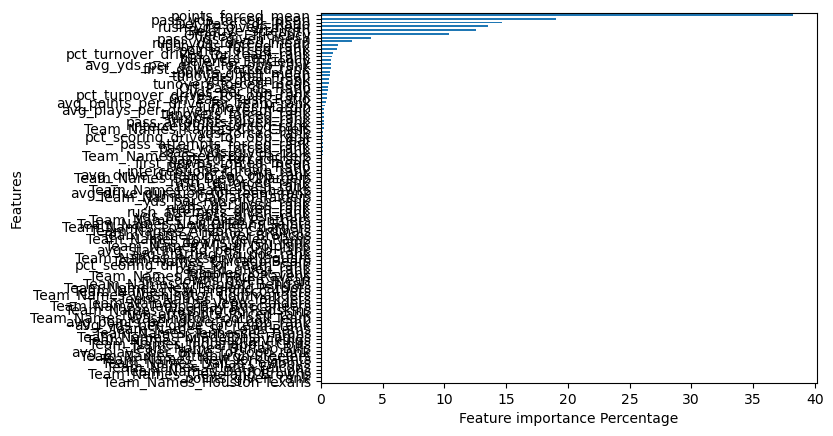

In [40]:
# Visual Python: Machine Learning > Model Info
# Very cluttered but still can see that many of the Team Names had little to no importance. 
# For future reference, we could drop the teams and add other dummy variables like offensive/defensive schemes, coaches names, players names, etc.
vp_plot_permutation_importances_all(model, X_train, y_train, sort=True)

In [41]:
def vp_plot_permutation_importances_top(model, X_train, y_train, scoring=None, sort=False, top_count=10):
    df_i = vp_create_permutation_importances(model, X_train, y_train, scoring=scoring, sort=sort)
                        
    if sort: 
        if top_count > 0:
            top_df = df_i.nlargest(top_count, 'Percentage')
            top_df['Percentage'].plot(kind='barh')
        else:
            df_i['Percentage'].plot(kind='barh')
    else: 
        df_i['Percentage'].plot(kind='barh')
    plt.xlabel('Feature importance Percentage')
    plt.ylabel('Features')
                        
    plt.show()

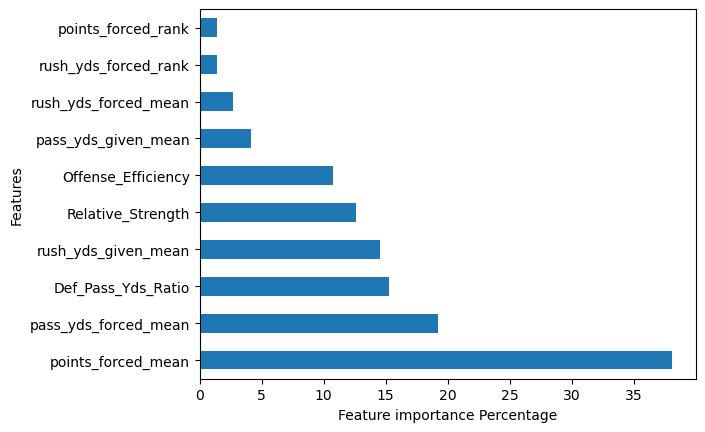

In [42]:
# These are the top features that made the linear regression model
# These features should be the y-axis values in the plots over time
vp_plot_permutation_importances_top(model, X_train, y_train, sort=True)

**Key Takeaways:**
- The amount of points a team can score is most important
- Def Pass Ratio was very important and we also should look at Def Rush Yds Ratio (dropped because it and def pass ratio added to a constant 1). Especially because rush yds given is higher in importance than pass yds given
- Two engineered features mmade the top 5 features so there might be better relationships that might improve the model

In [43]:
# Linear Regressions have their limitations in predicting since it is one straight line (two pararmeters: ie. slope and y-intercept) trying to predict the performance of a team with countless variables
# Below are the metrics to measure error in a linear regression model. Mean-squared error takes the distsnce of the test values from the predicted line and takes the average dof all the distances
# MAE is similar but looks at the magnitude of difference between the predicted and actual value
# It might not be perfect, but these features had a high importance in predicting the performance factor and would be worth further investigation

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)

MSE: 0.3577899031475894
MAE: 0.45174520925773215


*Error seems high but I think going from 98 features to 2 parameters for a best fit line, an average error of 30% to 40% is not bad.*

In [44]:
# This next step is to see what teams were best related to a linear relationship with the performance factor
# We can use the teams from this to track the trends per year based on the target feature (ie. points forced, Def pass yds ratio)
# I took out the Atlanta Falcolns because they were one of the least correlated teams in a test sample and I needed to drop one to avoid multicollinearity
X = master_df_all_stand[['Team_Names_Arizona Cardinals', 'Team_Names_Baltimore Ravens', 'Team_Names_Buffalo Bills', 'Team_Names_Carolina Panthers', 'Team_Names_Chicago Bears', 'Team_Names_Cincinnati Bengals', 'Team_Names_Cleveland Browns', 'Team_Names_Dallas Cowboys', 'Team_Names_Denver Broncos', 'Team_Names_Detroit Lions', 'Team_Names_Green Bay Packers', 'Team_Names_Houston Texans', 'Team_Names_Indianapolis Colts', 'Team_Names_Jacksonville Jaguars', 'Team_Names_Kansas City Chiefs', 'Team_Names_Las Vegas Raiders', 'Team_Names_Los Angeles Chargers', 'Team_Names_Los Angeles Rams', 'Team_Names_Miami Dolphins', 'Team_Names_Minnesota Vikings', 'Team_Names_New England Patriots', 'Team_Names_New Orleans Saints', 'Team_Names_New York Giants', 'Team_Names_New York Jets', 'Team_Names_Oakland Raiders', 'Team_Names_Philadelphia Eagles', 'Team_Names_Pittsburgh Steelers', 'Team_Names_San Diego Chargers', 'Team_Names_San Francisco 49ers', 'Team_Names_Seattle Seahawks', 'Team_Names_St. Louis Rams', 'Team_Names_Tampa Bay Buccaneers', 'Team_Names_Tennessee Titans', 'Team_Names_Washington Commanders', 'Team_Names_Washington Football Team', 'Team_Names_Washington Redskins']]
y = master_df_all_stand['Season_Performance_Factor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [45]:
X


,Team_Names_Arizona Cardinals,Team_Names_Baltimore Ravens,Team_Names_Buffalo Bills,Team_Names_Carolina Panthers,Team_Names_Chicago Bears,Team_Names_Cincinnati Bengals,Team_Names_Cleveland Browns,Team_Names_Dallas Cowboys,Team_Names_Denver Broncos,Team_Names_Detroit Lions,...,Team_Names_Pittsburgh Steelers,Team_Names_San Diego Chargers,Team_Names_San Francisco 49ers,Team_Names_Seattle Seahawks,Team_Names_St. Louis Rams,Team_Names_Tampa Bay Buccaneers,Team_Names_Tennessee Titans,Team_Names_Washington Commanders,Team_Names_Washington Football Team,Team_Names_Washington Redskins
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
444,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
445,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
446,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [46]:
# Created a seperate linear regression model to try to see what teams were most aligned with the performance factor
model_teams = LinearRegression()

In [47]:
model_teams.fit(X_train, y_train)
y_pred = model_teams.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# The mean squared errors are horrible but instead of using the teams to predict, we should look at their trends over the years and see where these teams ranked amongst other teams
print("MSE:", mse)
print("MAE:", mae)

MSE: 1.3035112328172105
MAE: 0.9066329742815001


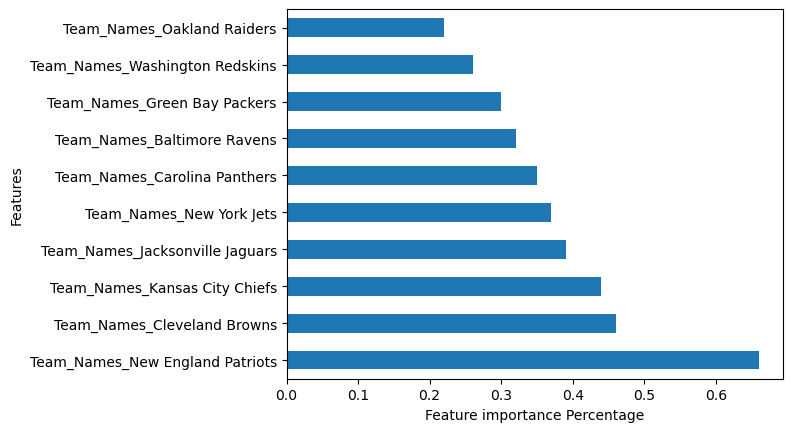

In [48]:
# Use the same plotting function as above
# Keep in mind that these teams are the ones that best fit the line that tried to predict the performance factor and this means the good and the bad teams
# in other words, these teams mattered most in making the best fit line
vp_plot_permutation_importances_top(model_teams, X_train, y_train,scoring=None, sort=True, top_count=10)

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\144818529.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot=master_df_all.pivot_table(values="Def_Pass_Yds_Ratio", index="Year",


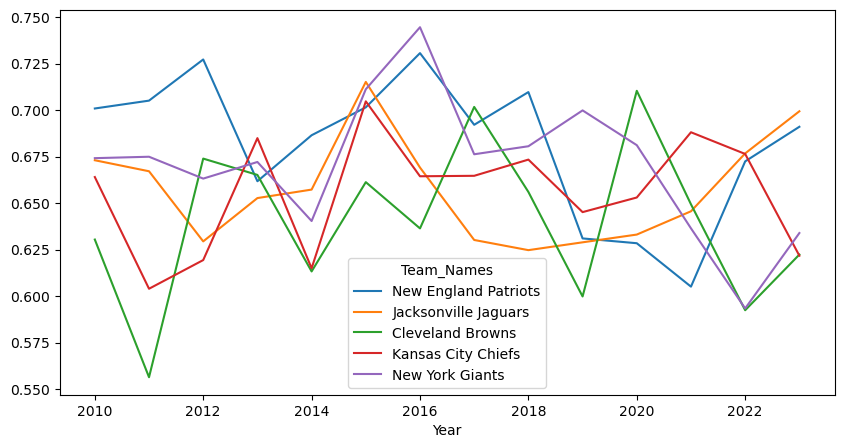

In [49]:
# Pass yards ratio plot
df_for_plot=master_df_all.pivot_table(values="Def_Pass_Yds_Ratio", index="Year",
                                 columns="Team_Names", aggfunc=sum)
dplot=df_for_plot[["New England Patriots","Jacksonville Jaguars", "Cleveland Browns","Kansas City Chiefs", "New York Giants"]].plot(kind='line', figsize=(10,5))

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\803197860.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot=master_df_all.pivot_table(values="Def_Pass_Yds_Ratio", index="Year",


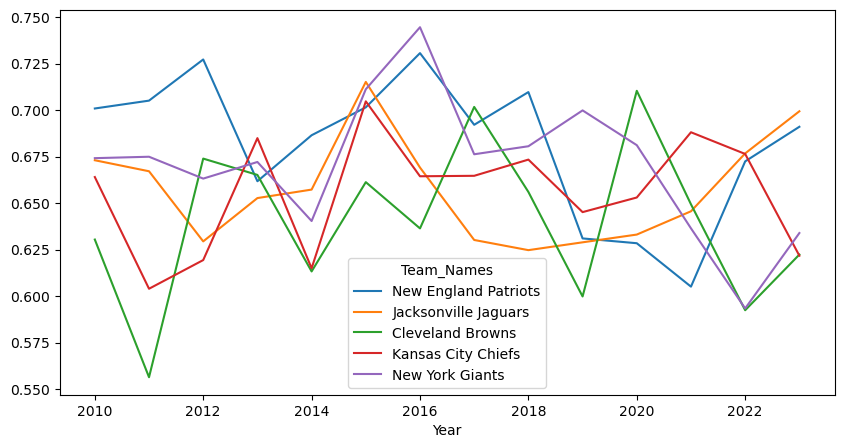

In [50]:
# Plt for defensive pass yards
df_for_plot=master_df_all.pivot_table(values="Def_Pass_Yds_Ratio", index="Year",
                                 columns="Team_Names", aggfunc=sum)
dplot=df_for_plot[["New England Patriots","Jacksonville Jaguars", "Cleveland Browns","Kansas City Chiefs", "New York Giants"]].plot(kind='line', figsize=(10,5))

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\2548913000.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot=master_df_all.pivot_table(values="pass_yds_forced_mean", index="Year",


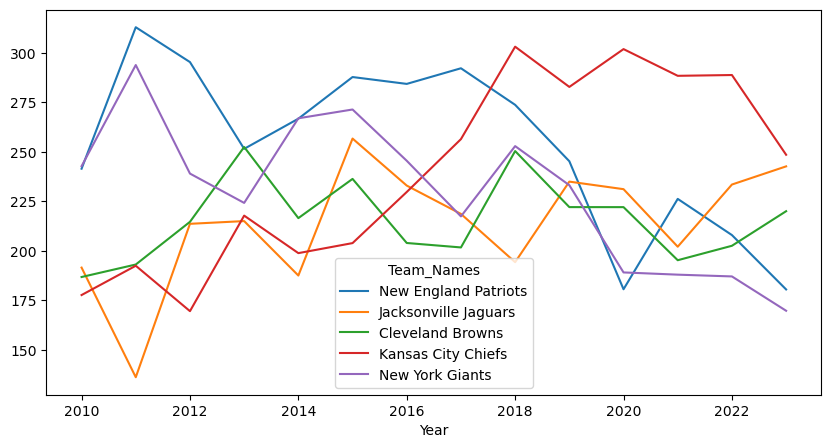

In [51]:
# Plot for pass yards forced
df_for_plot=master_df_all.pivot_table(values="pass_yds_forced_mean", index="Year",
                                 columns="Team_Names", aggfunc=sum)
dplot=df_for_plot[["New England Patriots","Jacksonville Jaguars", "Cleveland Browns","Kansas City Chiefs", "New York Giants"]].plot(kind='line', figsize=(10,5))

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\4281375197.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot=master_df_all.pivot_table(values="Season_Performance_Factor", index="Year",


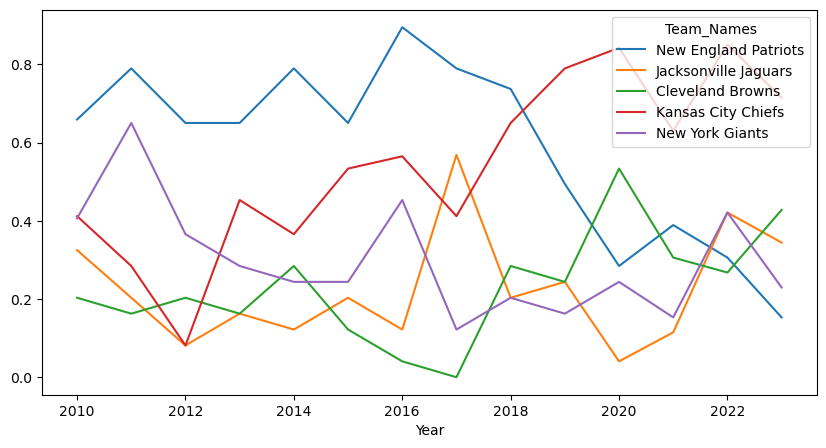

In [52]:
# Plot for Season Performace Factor
df_for_plot=master_df_all.pivot_table(values="Season_Performance_Factor", index="Year",
                                 columns="Team_Names", aggfunc=sum)
dplot=df_for_plot[["New England Patriots","Jacksonville Jaguars", "Cleveland Browns","Kansas City Chiefs", "New York Giants"]].plot(kind='line', figsize=(10,5))

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\3195508750.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot=master_df_all.pivot_table(values="Offense_Efficiency", index="Year",


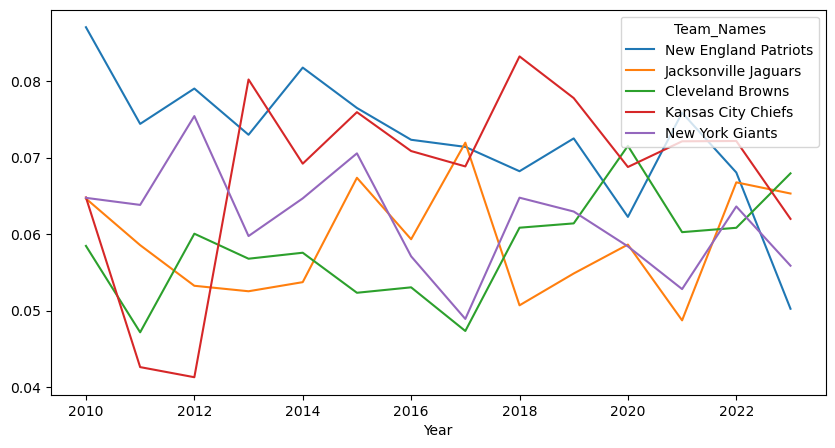

In [53]:
df_for_plot=master_df_all.pivot_table(values="Offense_Efficiency", index="Year",
                                 columns="Team_Names", aggfunc=sum)
dplot=df_for_plot[["New England Patriots","Jacksonville Jaguars", "Cleveland Browns","Kansas City Chiefs", "New York Giants"]].plot(kind='line', figsize=(10,5))

In [54]:
# Creating a dataframe for the average across all teams in each season for a given feature
consolidated_team_avgs = master_df_all.groupby('Year').agg(              
                                                            Season_Performance_mean=("Season_Performance_Factor", 'mean'),                    
                                                            points_forced_mean=('points_forced_mean', 'mean'), 
                                                            Def_Pass_Ratio_mean=("Def_Pass_Yds_Ratio", 'mean'),
                                                            Def_Rush_Ratio_mean=("Def_Rush_Yds_Ratio", 'mean'),
                                                            pass_yds_forced_mean=('pass_yds_forced_mean', 'mean'), 
                                                            rush_yds_forced_mean=('rush_yds_forced_mean', 'mean'), 
                                                            pass_yds_given_mean=('pass_yds_given_mean', 'mean'), 
                                                            rush_yds_given_mean=('rush_yds_given_mean', 'mean'),
                                                            Offense_Efficiency_mean=("Offense_Efficiency", 'mean')
                                                            ).reset_index()
consolidated_team_avgs['Year'].astype(int)
consolidated_team_avgs

,Year,Season_Performance_mean,points_forced_mean,Def_Pass_Ratio_mean,Def_Rush_Ratio_mean,pass_yds_forced_mean,rush_yds_forced_mean,pass_yds_given_mean,rush_yds_given_mean,Offense_Efficiency_mean
0,2010,0.363216,22.078479,0.660377,0.339623,221.372098,113.944781,221.774430,114.606054,0.065552
1,2011,0.364092,22.083780,0.662350,0.337650,229.911027,116.997120,230.673181,117.488570,0.063052
2,2012,0.362321,22.726227,0.664758,0.335242,232.063824,116.270903,232.424259,117.101332,0.064904
3,2013,0.363246,23.281227,0.675076,0.324924,235.236130,112.851632,236.096753,113.493340,0.066703
4,2014,0.362098,22.483129,0.680650,0.319350,236.324101,110.728921,237.123162,111.573231,0.064371
5,2015,0.364959,22.603774,0.691333,0.308667,242.839590,108.154667,243.512147,109.060693,0.064238
6,2016,0.361207,22.753478,0.690259,0.309741,241.734092,108.400999,242.122051,108.872629,0.064596
7,2017,0.364486,21.658401,0.673625,0.326375,225.789609,108.972476,226.456706,109.815830,0.064383
8,2018,0.361329,23.106953,0.675056,0.324944,237.152074,113.729045,237.633275,114.584626,0.065507
9,2019,0.363002,22.710192,0.673330,0.326670,234.385906,112.962643,234.692659,113.705464,0.065086


C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\2367929856.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot = master_df_all.pivot_table(values="Season_Performance_Factor", index="Year",


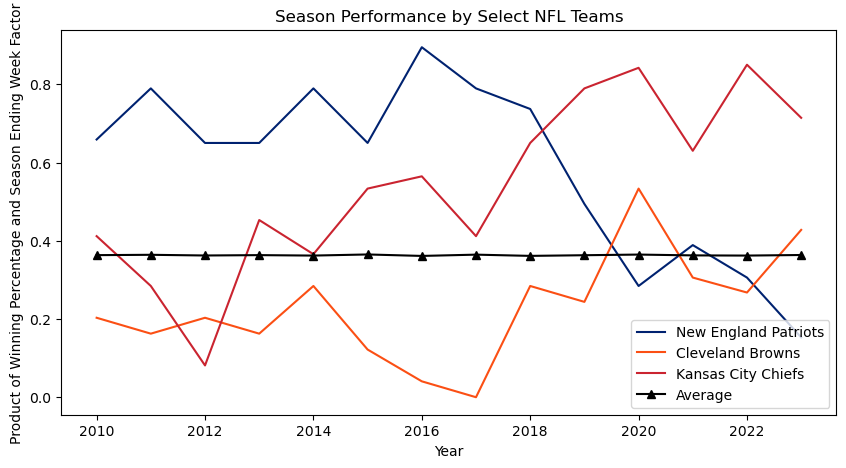

In [68]:
# Pivot the data to create a table with the total rushing yards given up by each team for each year
df_for_plot = master_df_all.pivot_table(values="Season_Performance_Factor", index="Year",
                                        columns="Team_Names", aggfunc=sum)

# Select the teams to include in the plot
teams = ["New England Patriots", "Cleveland Browns","Kansas City Chiefs"]
team_colors = {'New England Patriots': '#002270',
               'Cleveland Browns': '#FB4F14',
               'Kansas City Chiefs': '#CA2430'}

# Create the line plot
dplot = df_for_plot[teams].plot(kind='line', figsize=(10,5), color=[team_colors[team] for team in teams])

# Add labels and title
dplot.set_xlabel("Year")
dplot.set_ylabel("Product of Winning Percentage and Season Ending Week Factor")
dplot.set_title("Season Performance by Select NFL Teams")

dplot.plot(consolidated_team_avgs['Year'], consolidated_team_avgs['Season_Performance_mean'], label='Average', color='black', marker='^')

# Add a legend
dplot.legend(loc='lower right')

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\286572600.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot = master_df_all.pivot_table(values="points_forced_mean", index="Year",


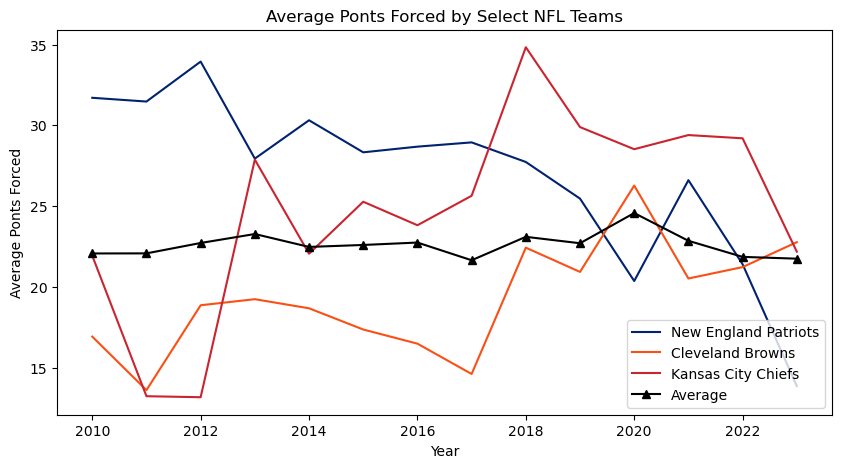

In [67]:
# Pivot the data to create a table with the total rushing yards given up by each team for each year
df_for_plot = master_df_all.pivot_table(values="points_forced_mean", index="Year",
                                        columns="Team_Names", aggfunc=sum)

# Create the line plot
dplot = df_for_plot[teams].plot(kind='line', figsize=(10,5), color=[team_colors[team] for team in teams])

# Add labels and title
dplot.set_xlabel("Year")
dplot.set_ylabel("Average Ponts Forced")
dplot.set_title("Average Ponts Forced by Select NFL Teams")

dplot.plot(consolidated_team_avgs['Year'], consolidated_team_avgs['points_forced_mean'], label='Average', color='black', marker='^')

# Add a legend
dplot.legend(loc='lower right')

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\4176351342.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot = master_df_all.pivot_table(values="Def_Pass_Yds_Ratio", index="Year",


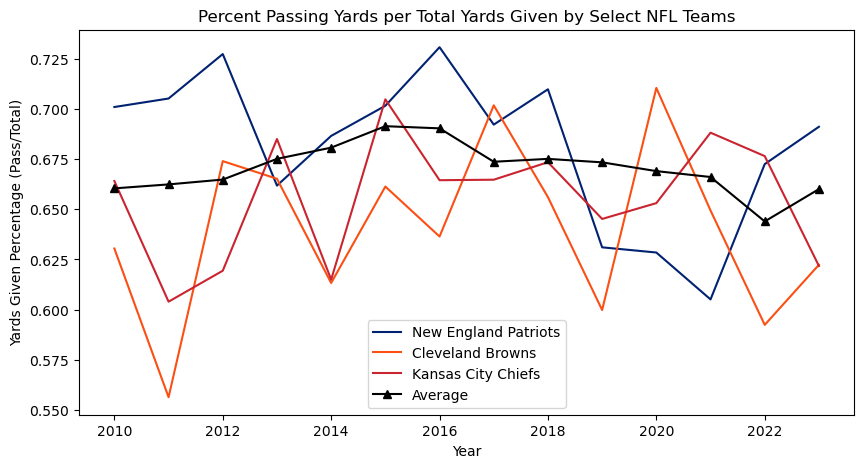

In [66]:
# Pivot the data to create a table with the total rushing yards given up by each team for each year
df_for_plot = master_df_all.pivot_table(values="Def_Pass_Yds_Ratio", index="Year",
                                        columns="Team_Names", aggfunc=sum)

# Create the line plot
dplot = df_for_plot[teams].plot(kind='line', figsize=(10,5), color=[team_colors[team] for team in teams])

# Add labels and title
dplot.set_xlabel("Year")
dplot.set_ylabel("Yards Given Percentage (Pass/Total)")
dplot.set_title("Percent Passing Yards per Total Yards Given by Select NFL Teams")

dplot.plot(consolidated_team_avgs['Year'], consolidated_team_avgs['Def_Pass_Ratio_mean'], label='Average', color='black', marker='^')

# Add a legend
dplot.legend(loc='lower center')

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\104555132.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot = master_df_all.pivot_table(values="Def_Rush_Yds_Ratio", index="Year",


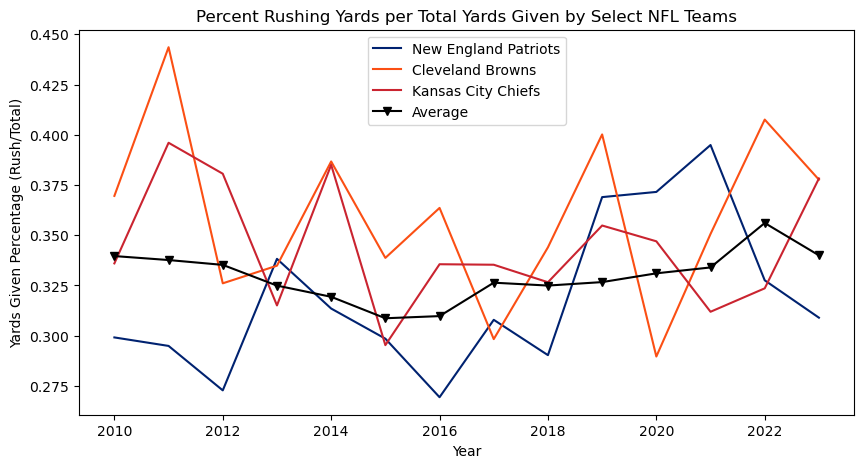

In [65]:
# Pivot the data to create a table with the total rushing yards given up by each team for each year
df_for_plot = master_df_all.pivot_table(values="Def_Rush_Yds_Ratio", index="Year",
                                        columns="Team_Names", aggfunc=sum)


# Create the line plot
dplot = df_for_plot[teams].plot(kind='line', figsize=(10,5), color=[team_colors[team] for team in teams])

# Add labels and title
dplot.set_xlabel("Year")
dplot.set_ylabel("Yards Given Percentage (Rush/Total)")
dplot.set_title("Percent Rushing Yards per Total Yards Given by Select NFL Teams")

dplot.plot(consolidated_team_avgs['Year'], consolidated_team_avgs['Def_Rush_Ratio_mean'], label='Average', color='black', marker='v')

# Add a legend
dplot.legend(loc='upper center')

**Above Plot is Significant because trend patterns are similar the inverse of the Performance Factor Trends**

**I'm assuming the reason for this is that if your opponent is able to run the ball on your team, they can bleed the clock out and prevent you from Passing.**


C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\3245872674.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot = master_df_all.pivot_table(values="pass_yds_forced_mean", index="Year",


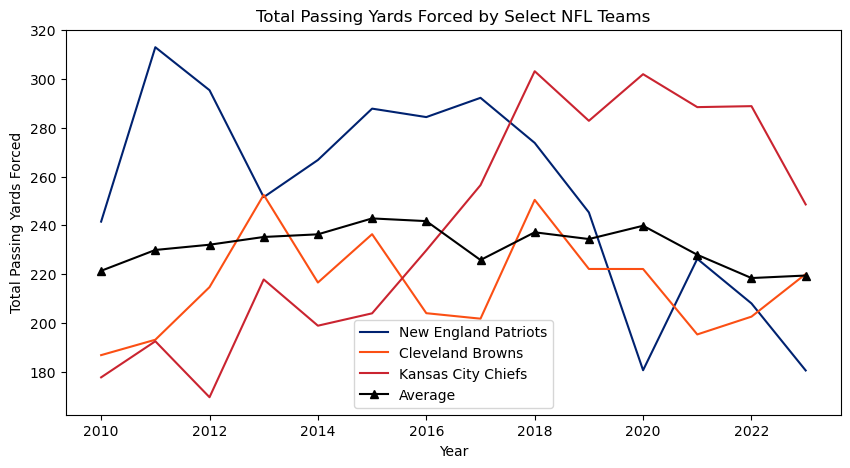

In [64]:
# Pivot the data to create a table with the total rushing yards given up by each team for each year
df_for_plot = master_df_all.pivot_table(values="pass_yds_forced_mean", index="Year",
                                        columns="Team_Names", aggfunc=sum)

# Create the line plot
dplot = df_for_plot[teams].plot(kind='line', figsize=(10,5), color=[team_colors[team] for team in teams])

# Add labels and title
dplot.set_xlabel("Year")
dplot.set_ylabel("Total Passing Yards Forced")
dplot.set_title("Total Passing Yards Forced by Select NFL Teams")


dplot.plot(consolidated_team_avgs['Year'], consolidated_team_avgs['pass_yds_forced_mean'], label='Average', color='black', marker='^')

# Add a legend
dplot.legend(loc='lower center')


Another significant pattern that matches the Performance Factor

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\840024347.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot = master_df_all.pivot_table(values="rush_yds_forced_mean", index="Year",


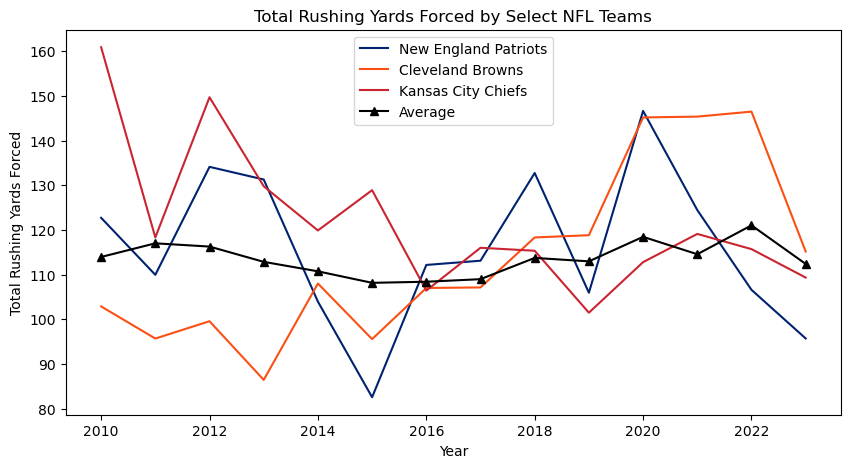

In [60]:
# Pivot the data to create a table with the total rushing yards given up by each team for each year
df_for_plot = master_df_all.pivot_table(values="rush_yds_forced_mean", index="Year",
                                        columns="Team_Names", aggfunc=sum)

# Create the line plot
dplot = df_for_plot[teams].plot(kind='line', figsize=(10,5), color=[team_colors[team] for team in teams])

# Add labels and title
dplot.set_xlabel("Year")
dplot.set_ylabel("Total Rushing Yards Forced")
dplot.set_title("Total Rushing Yards Forced by Select NFL Teams")


dplot.plot(consolidated_team_avgs['Year'], consolidated_team_avgs['rush_yds_forced_mean'], label='Average', color='black', marker='^')

# Add a legend
dplot.legend(loc='upper center')

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\1326849414.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot = master_df_all.pivot_table(values="pass_yds_given_mean", index="Year",


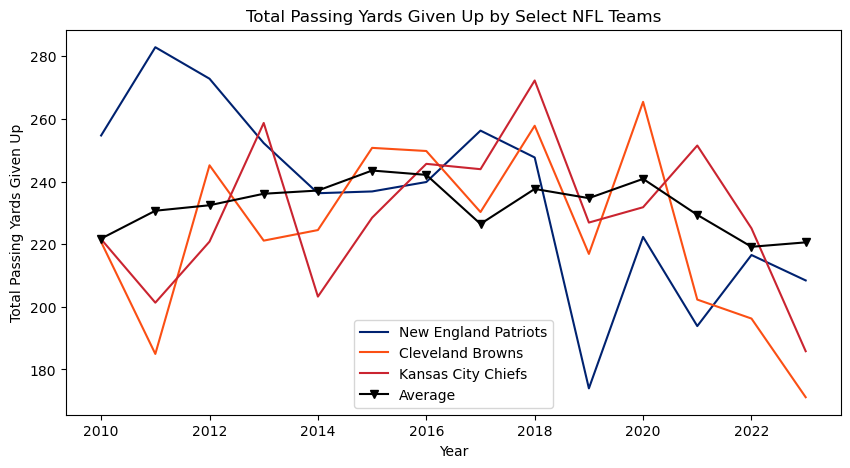

In [63]:
# Pivot the data to create a table with the total rushing yards given up by each team for each year
df_for_plot = master_df_all.pivot_table(values="pass_yds_given_mean", index="Year",
                                        columns="Team_Names", aggfunc=sum)

# Create the line plot
dplot = df_for_plot[teams].plot(kind='line', figsize=(10,5), color=[team_colors[team] for team in teams])

# Add labels and title
dplot.set_xlabel("Year")
dplot.set_ylabel("Total Passing Yards Given Up")
dplot.set_title("Total Passing Yards Given Up by Select NFL Teams")

# Create a line for the consolidated_team_avgs['pass_yds_given_mean'] indexed by consolidated_team_avgs['Year']
dplot.plot(consolidated_team_avgs['Year'], consolidated_team_avgs['pass_yds_given_mean'], label='Average', color='black', marker='v')

# Add a legend
dplot.legend(loc='lower center')


***Bill didn't care about other teams passing on him because he had the GOAT. He switched his scheme knowing that Tom Brady would be leaving soon and tried to compensate a poor passing offense with an elite pass defense. But elite passing offenses still are the most important thing to a successful season in the NFL.***

C:\Users\ryanc\AppData\Local\Temp\ipykernel_11376\1974760733.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_for_plot = master_df_all.pivot_table(values="rush_yds_given_mean", index="Year",


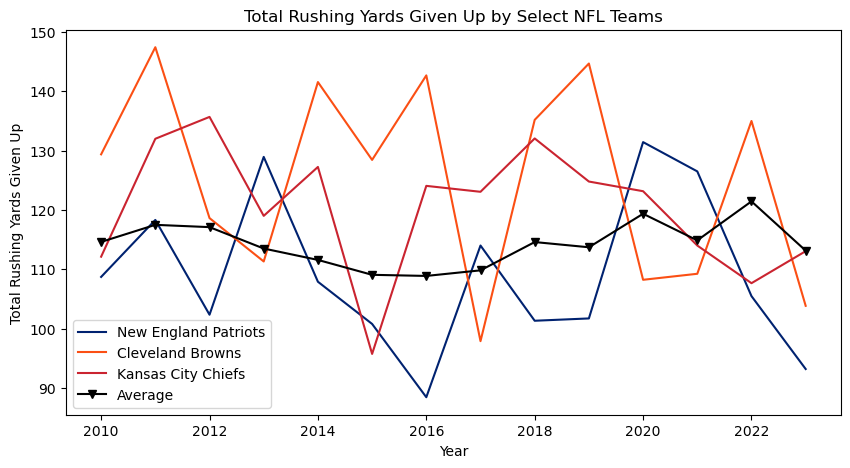

In [62]:
# Pivot the data to create a table with the total rushing yards given up by each team for each year
df_for_plot = master_df_all.pivot_table(values="rush_yds_given_mean", index="Year",
                                        columns="Team_Names", aggfunc=sum)

# Create the line plot
dplot = df_for_plot[teams].plot(kind='line', figsize=(10,5), color=[team_colors[team] for team in teams])

# Add labels and title
dplot.set_xlabel("Year")
dplot.set_ylabel("Total Rushing Yards Given Up")
dplot.set_title("Total Rushing Yards Given Up by Select NFL Teams")

# Create a line for the consolidated_team_avgs['rush_yds_given_mean'] indexed by consolidated_team_avgs['Year']
dplot.plot(consolidated_team_avgs['Year'], consolidated_team_avgs['rush_yds_given_mean'], label='Average', color='black', marker='v')

# Add a legend
dplot.legend(loc='lower left')

